## Phylogeny analysis antibodies

This notebook needs two dataset to run:
- The GISAID database (https://www.gisaid.org/) require scientific credentials and a login. The dataset used is in EpiCov → Download → spikeprot????. Save this one in Additional_data/whole_genome_sequencing/spikeprot????.fasta
- The COG global tree can be downloaded from [here](https://microreact.org/project/suVnc6aexZY5a7dWM6tcfs-global-sars-cov-2-2019-12-242022-02-11) (javascript app, really slow)



In [2]:
import pandas as pd
import ete3
import json
from Bio import SeqIO
from tqdm.notebook import tqdm
import pickle
mutation_names = ['G339D','S371L','S373P','S375F','K417N','N440K','G446S','S477N',
                  'T478K','E484A','Q493R','G496S','Q498R','N501Y','Y505H']


In [3]:
1+1

2

In [ ]:
import regex as re


#load the sequences

rbds = {}
for record in SeqIO.parse("./../../Additional_data/spikeprot0613/spikeprot0613.fasta", "fasta"):
    rbds[record.id] = str(record.seq)[330:531]

    
rbds_newkey = {}
for a in rbds:
    try:
        nm = a.split("|")[3]
    except:
        nm = ''
    if nm != '':
        rbds_newkey[nm] = rbds[a]
rbds = rbds_newkey.copy()
   

In [2]:
 
def omicron_mutations(s):
    bi = ''
    our_sequence = r"^NITNLCPF(G|D)EVFNATRFASVYAWNRKRISNCVADYSVLYN(S|L)A(S|P)F(S|F)TFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTG(K|N)IADYNYKLPDDFTGCVIAWNSN(N|K)LDSKV(G|S)GNYNYLYRLFRKSNLKPFERDISTEIYQAG(S|N)(T|K)PCNGV(E|A)GFNCYFPL(Q|R)SY(G|S)F(Q|R)PT(N|Y)GVG(Y|H)QPYRVVVLSFELLHAPATVCGPKKST$"
    if not re.match(our_sequence, s):
        return "X"*15
    
    mutation_names = ['G339D','S371L','S373P','S375F','K417N','N440K','G446S','S477N','T478K','E484A','Q493R','G496S','Q498R','N501Y','Y505H']
    for a in mutation_names:
        w, o, pos = a[0], a[-1], int(a[1:-1])
        if s[pos - 331] == w:
            bi += '0'
        elif s[pos - 331] == o:
            bi += '1'
        else:
            bi += 'X'
    return bi

muts = {}
for a in tqdm(rbds):
    if len(rbds[a]) == 201:
        bi = omicron_mutations(rbds[a])
        if 'X' not in bi:
            muts[a] = bi
        
import pickle
with open("gisaid_data_omicron_mutations.pkl", "wb") as fw:
    pickle.dump(muts, fw)


KeyboardInterrupt



In [ ]:
with open("gisaid_data_omicron_mutations.pkl", "rb") as f:
    muts = pickle.load(f)

## tree recreation

In [5]:
import ete3

t = ete3.Tree("./../../Additional_data/GISAID-hCoV-19-phylogeny-2022-05-04/global.tree",
             quoted_node_names=True, format=1)

In [6]:
shared_key = set([a.name for a in t.traverse()]) & set(list(rbds.keys()))
shared_key = [a for a in shared_key if a != '']
#t.prune(shared_key)

In [ ]:
lenghts = [len(a.sequence) for a in t]


In [27]:
length = 201

In [30]:
from collections import Counter

def consensus_sequence(a):
    if len(a.children) == 0:
        return ""
    mdist = min([c.dist for c in a.children])
    seqs = [c.sequence for c in a.children if c.dist == mdist and len(c.sequence) == length]
    result = []
    for ii in range(length):
        most_common = Counter([s[ii] for s in seqs]).most_common(1)
        if len(most_common) == 0:
            result += ['X']
        else:
            result += [most_common[0][0]]
        
    return "".join(result)

In [31]:
for a in tqdm(t.traverse()):
    a.sequence = rbds[a.name] if a.name in rbds else ''
    
for a in tqdm(list(t.traverse())[::-1]):
    if a.sequence == '':
        a.sequence = consensus_sequence(a)

In [46]:
import regex

## transform the sequence in binary form
def omicron_mutations(s):
    bi = ''
    our_sequence = r"^(NITNLCPF(G|D)EVFNATRFASVYAWNRKRISNCVADYSVLYN(S|L)A(S|P)F(S|F)TFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTG(K|N)IADYNYKLPDDFTGCVIAWNSN(N|K)LDSKV(G|S)GNYNYLYRLFRKSNLKPFERDISTEIYQAG(S|N)(T|K)PCNGV(E|A)GFNCYFPL(Q|R)SY(G|S)F(Q|R)PT(N|Y)GVG(Y|H)QPYRVVVLSFELLHAPATVCGPKKST){s<=10}$"
    if not regex.match(our_sequence, s):
        return "X"*15
    
    mutation_names = ['G339D','S371L','S373P','S375F','K417N','N440K','G446S','S477N','T478K','E484A','Q493R','G496S','Q498R','N501Y','Y505H']
    for a in mutation_names:
        w, o, pos = a[0], a[-1], int(a[1:-1])
        if s[pos - 331] == w:
            bi += '0'
        elif s[pos - 331] == o:
            bi += '1'
        else:
            bi += 'X'
    return bi

for a in tqdm(t.traverse()):
    a.binary = omicron_mutations(a.sequence)

In [65]:
from collections import defaultdict

mutations_count_498501 = defaultdict(int)
for n in tqdm(t.traverse()):
    if n.binary[-2] == '1' and n.binary[-3] == '1':
        muts = []
        for c in n.children:
            muts += [a for a, (x, y) in enumerate(zip(n.binary, c.binary)) if x == '0' and y == '1']
        muts = set(muts)
        for m in muts:
            mutations_count_498501[m] += 1

In [62]:
mutations_count = defaultdict(int)
for n in tqdm(t.traverse()):
    muts = []
    for c in n.children:
        muts += [a for a, (x, y) in enumerate(zip(n.binary, c.binary)) if x == '0' and y == '1']
    muts = set(muts)
    for m in muts:
        mutations_count[m] += 1

In [66]:
df = pd.Series(mutations_count, name="Count").to_frame().rename_axis("Mutation_idx").reset_index()
df["Mutation"] = df.Mutation_idx.apply(lambda ii: mutation_names[ii])
df["Count_498501"] = df.Mutation_idx.map(mutations_count_498501)
df = df.sort_values(by="Mutation_idx")
df["Proportion"] = df["Count"]/df.Count.sum()
df["Proportion_498501"] = df["Count_498501"]/df.Count_498501.sum()


Text(0, 0.5, 'Frequency in phylogeny, post 498-501')

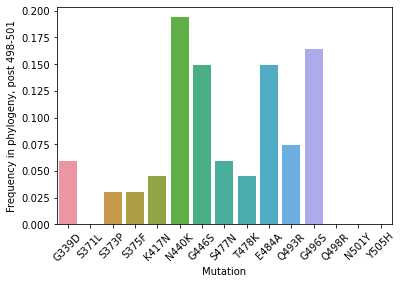

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.barplot(data=df, x="Mutation", y="Proportion_498501", ax=ax)
plt.xticks(rotation=45)
plt.ylabel("Frequency in phylogeny, post 498-501")

In [ ]:
df["Count_498501"]

In [177]:
import itertools
mutations_count = defaultdict(int)
for n in t.traverse():
    muts = []
    for c in n.children:
        muts += [[a for a, (x, y) in enumerate(zip(n.binary, c.binary)) if x != y]]
    for group_mut in muts:
        for m1, m2 in itertools.permutations(group_mut, r=2):
            mutations_count[m1, m2] += 1

In [178]:
df2 = pd.Series(mutations_count, name="Count").to_frame().rename_axis(["Mutation1_idx", "Mutation2_idx"]).reset_index()
df2["Mutation1"] = df2.Mutation1_idx.apply(lambda ii: mutation_names[ii])
df2["Mutation2"] = df2.Mutation2_idx.apply(lambda ii: mutation_names[ii])
df2 = df2[df2.Mutation1 == "N501Y"]
df2 = df2.sort_values(by="Mutation2_idx")
#df["Proportion"] = df["Count"]/df.Count.sum()
#df.to_csv("Proportion_branch_mutation_happens.csv")

<AxesSubplot:xlabel='Mutation2', ylabel='Count'>

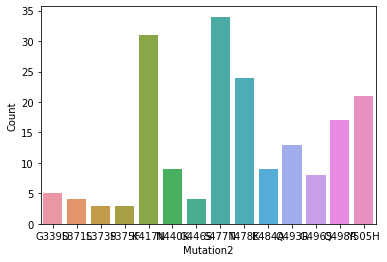

In [ ]:
dfpl.N501Y.to_csv("Proportion_happen_same_time_N501_normalized.csv")

In [ ]:
## antibody analyse

In [ ]:
with_501498 = set([a.name for a in t.traverse()]) 
t.prune(with_501498)